In [1]:
import jax
import jax.numpy as jnp
from jax import vmap
import optax
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# use float64
from jax.config import config
config.update("jax_enable_x64", True)

# use retina plots
%config InlineBackend.figure_format='retina'

# generate data

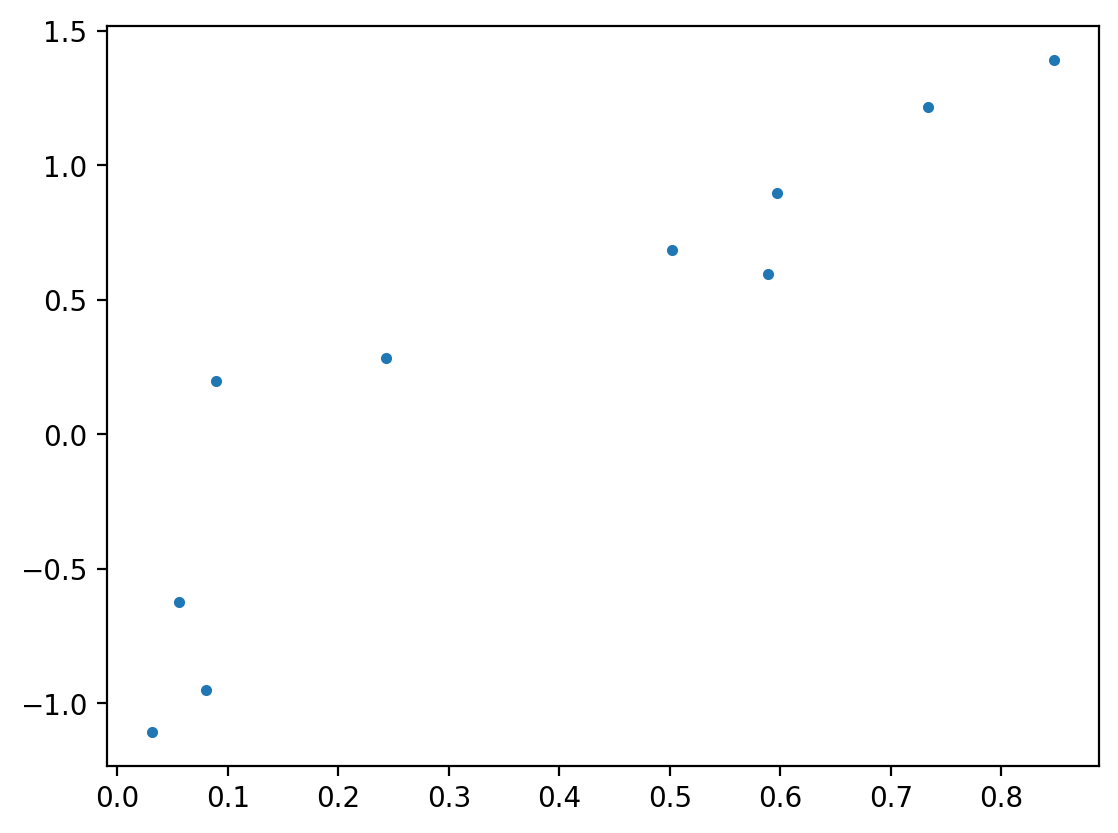

In [3]:
# generate train data
n_train = 10
noise_sd = 0.4
ds_key = jax.random.PRNGKey(0)
x_key, y_key = jax.random.split(ds_key, 2)
x_train = jax.random.uniform(x_key, [n_train])
y_train = x_train - 10*(0.5-x_train)**3 
y_train += noise_sd * jax.random.normal(y_key, [n_train])
assert x_train.dtype == jnp.float64
plt.plot(x_train, y_train, '.');

# fit+predict functions

In [4]:
def primal_predict(x_train, y_train, x_test):
    w = jnp.linalg.lstsq(x_train, y_train, rcond=None)[0]
    y_hat = x_test @ w
    return y_hat

def dual_predict(x_train, y_train, x_test, kernel_fn, gamma):
    kernel_fn_vect = vmap(vmap(kernel_fn, in_axes=[None, 0]), in_axes=[0, None])
    K = kernel_fn_vect(x_train, x_train)
    alpha = jnp.linalg.lstsq(K + n_train*gamma, y_train, rcond=None)[0]
    y_hat = kernel_fn_vect(x_test, x_train) @ alpha
    return y_hat

# define kernels, basis functions

In [5]:
def linear_kernel(x1, x2, k):
    return jnp.dot(x1, x2)

def poly_kernel(x1, x2, k):
    return (jnp.dot(x1, x2) + 1)**k

def poly_basis(x, k):
    return vmap(lambda i: x**i)(jnp.arange(k)).T

# plot fits

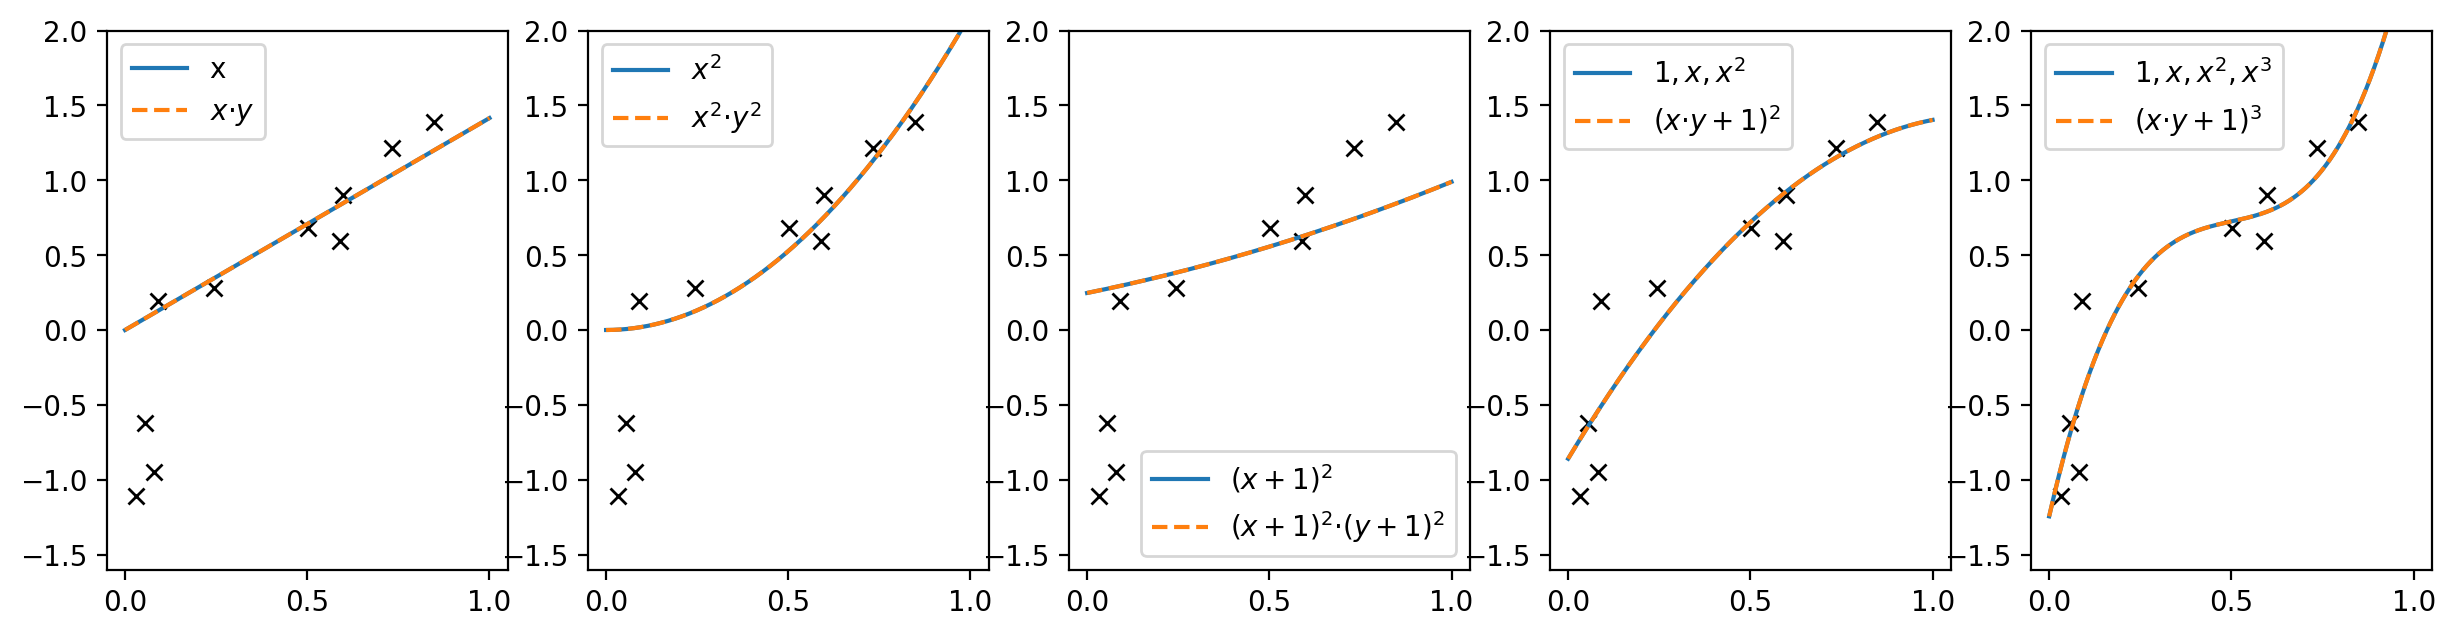

In [6]:
# use small gamma, so there's almost no regularization
gamma = 1e-20

# points to evaluate
x_plot = jnp.linspace(0, 1, 1000)

mappings = [[lambda x: x[:, None], r'x', lambda x, y: jnp.dot(x, y), r'$x·y$'],
            [lambda x: x[:, None]**2, r'$x^2$', lambda x, y: jnp.dot(x**2, y**2), r'$x^2 · y^2$'],
            [lambda x: (x+1)[:, None]**2, r'$(x+1)^2$', lambda x, y: jnp.dot((x+1)**2, (y+1)**2), r'$(x+1)^2·(y+1)^2$'],
            [lambda x: poly_basis(x, 3), r'$1, x, x^2$', lambda x, y: (jnp.dot(x, y)+1)**2, r'$(x·y+1)^2$'],
            [lambda x: poly_basis(x, 4), r'$1, x, x^2, x^3$', lambda x, y: (jnp.dot(x, y)+1)**3, r'$(x·y+1)^3$'],
]

# plot fits
fig, axs = plt.subplots(1, len(mappings), figsize=[15, 3.5])
for i, mapping in enumerate(mappings):
    basis_fn, basis_lab, kernel_fn, kernel_lab = mapping
    
    # plot data
    axs[i].plot(x_train, y_train, 'x', c='black')
    
    # primal solution
    x_train_expanded = basis_fn(x_train)
    x_test_expanded = basis_fn(x_plot)
    y_hat_primal = primal_predict(x_train_expanded, y_train, x_test_expanded)
    axs[i].plot(x_plot, y_hat_primal, label=basis_lab)
    
    # dual solution
    y_hat_dual = dual_predict(x_train[:, None], y_train, x_plot[:, None], kernel_fn, gamma)
    axs[i].plot(x_plot, y_hat_dual, label=kernel_lab, ls='--')
    
    # misc
    axs[i].legend()
    axs[i].set_ylim([-1.6, 2])
    

plt.show()